# ***Hand Gesture Classification***

- Đầu vào: Hình ảnh hành động của tay
- Đầu ra: dự đoán nhãn cho hành động mà tay đang làm
- Bài toán: multi-class classification (phân loại đa lớp), phân loại các hand gestures vào các lớp

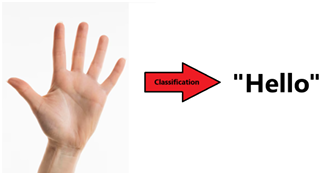

Bài toán này có thể có nhiều cách tiếp cận khác nhau.
- Nếu xét theo cách thu nhận và biểu diễn cử chỉ tay thì bài toán có thể được chia thành **skeleton based** và **box/filter-based**.

- Còn nếu xét dựa trên kỹ thuật nhận dạng, bài toán có thể chia thành cách tiếp cận **sử dụng Neural Networks** (Deep Learning Approaches) và **không dùng Neural Networks**.

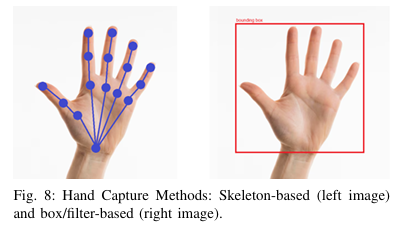


Nhóm sẽ phân tích theo 3 hướng: box/filter-based + ML, box/filter-based + DL, skeleton-based + DL

# **A. Chuẩn bị dataset**

Dataset: **NUS Hand Posture Dataset 2**, gồm 2000 ảnh hand postures, 750 ảnh hand postures có nhiễu; gồm 10 lớp (classes)

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [15]:
import os
download_path = '/content/drive/MyDrive/HandGestureRecognition/datasets'
os.makedirs(download_path, exist_ok = True)

url = 'https://www.ece.nus.edu.sg/stfpage/elepv/NUS-HandSet/NUS-Hand-Posture-Dataset-II.zip'
file_name = 'NUS-Hand-Posture-Dataset-II.zip'

!wget -O $download_path/$file_name $url

--2025-05-16 19:21:38--  https://www.ece.nus.edu.sg/stfpage/elepv/NUS-HandSet/NUS-Hand-Posture-Dataset-II.zip
Resolving www.ece.nus.edu.sg (www.ece.nus.edu.sg)... 137.132.5.15
Connecting to www.ece.nus.edu.sg (www.ece.nus.edu.sg)|137.132.5.15|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 77233719 (74M) [application/x-zip-compressed]
Saving to: ‘/content/drive/MyDrive/HandGestureRecognition/datasets/NUS-Hand-Posture-Dataset-II.zip’

/content/drive/MyDr 100%[===================>]  73.66M   307KB/s    in 4m 22s  

2025-05-16 19:26:04 (288 KB/s) - ‘/content/drive/MyDrive/HandGestureRecognition/datasets/NUS-Hand-Posture-Dataset-II.zip’ saved [77233719/77233719]



In [17]:
zip_file_path = os.path.join(download_path, file_name)
extract_path = os.path.join(download_path, 'extracted/')
os.makedirs(extract_path, exist_ok=True)

# Giải nén file ZIP
!unzip -q {zip_file_path} -d {extract_path}

# **B. Định nghĩa mô hình**

## I. Box/filter-based  - ML

Sử dụng SVM + HOG (Histogram of gradients)

## II. Box/filter-based + DL
Sử dụng mạng CNN để trích xuất đặc trưng và gán nhãn

## III. Skeleton-based + DL
Sử dụng mediapipe + MLP

#**B. So sánh kết quả, nhận xét và kểt luận**

#**C. Tài liệu tham khảo**
1. Linardakis, Manousos, Iraklis Varlamis, and Georgios Th Papadopoulos. "Survey on Hand Gesture Recognition from Visual Input." arXiv preprint arXiv:2501.11992 (2025).